## We try to build a proper N dimensional thermal state for a quantum Ising model

$$ H = -J\sum_i^{N-1}{\sigma_i^z\sigma_{i+1}^z}-h\sum_i^{N-1}{\sigma_i^x} $$
#### The thermal state is defined as:
$$\rho = \frac{e^{\beta H}}{Z}$$

### it can be also interesting to know that 1D systems have been solved exactly and that the value of the correlation length reeds:
$$\xi = \frac{1}{|ln(\frac{h}{J})|}$$

In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import Axes3D
print(qt.__version__)

5.0.4


In [2]:
def create_thermal_state(N,J,h,beta):

    H = 0

    for i in range(N - 1):
        ops = [qt.qeye(2)] * N  # start with all identities
        ops[i] = qt.sigmaz()    # put σ_z at position i
        ops[i + 1] = qt.sigmaz()  # put σ_z at position i+1
        H += -J * qt.tensor(ops)

    for i in range(N):
        ops = [qt.qeye(2)] * N
        ops[i] = qt.sigmax()
        H += -h * qt.tensor(ops)

    rho_thermal = (-beta * H).expm()
    rho_thermal /= rho_thermal.tr()  # normalization

    return rho_thermal

def force_diagonal(rho, threshold=1e-10):
    rho_matrix = rho.full()  # Convert to numpy array
    rho_diag = np.diag(np.diag(rho_matrix))  # Keep diagonal only
    rho_diag[np.abs(rho_diag) < threshold] = 0.0  # Threshold small elements
    rho_diag /= np.trace(rho_diag)  # Re-normalize
    return qt.Qobj(rho_diag, dims=rho.dims)

def corr_length(h,J):
    return 1/(np.abs(np.log(h/J)))

def generate_partitions(n):
    assert n % 2 == 1, "n must be odd"
    
    partitions = []
    half = (n - 1) // 2
    a = list(range(0, half))
    c = [half]
    b = list(range(half + 1, n))
    
    # Store initial partition
    partitions.append({"a": a[:], "c": c[:], "b": b[:]})
    
    toggle = True  # True: move from a → c, False: b → c
    
    while len(a) > 1 or len(b) > 1:
        if toggle and len(a) > 1:
            # Move largest from a to front of c
            c.insert(0, a.pop())
        elif not toggle and len(b) > 1:
            # Move smallest from b to end of c
            c.append(b.pop(0))
        toggle = not toggle
        partitions.append({"a": a[:], "c": c[:], "b": b[:]})
    
    return partitions



## 1)  We first compute simple mutual informations for different partitions and number of particles

### 1.1) Lets first compare the classical case (h = 0) with the quantum case (h != 0) at high temperature

In [75]:
N_max = 11
h_m = 2
J = 1
beta = 1
spac = 30

I = [None] * spac

j = 0

for h in np.linspace(0, h_m, spac):

    I_h = np.zeros(N_max-2)

    for n in range(2,N_max):
        p,b,a = 0,0,0
        p = create_thermal_state(n,J,h,beta)

        # need to create the separation:
        a, b = np.split(np.arange(n ), [ (n ) // 2 ])
        p_A = p.ptrace(a)
        p_B = p.ptrace(b)
        if h == 0:
            p = force_diagonal(p)
            p_A = force_diagonal(p_A)
            p_B = force_diagonal(p_B)
        
        I_h[n-2] = qt.entropy_vn(p_A, base=2) + qt.entropy_vn(p_B, base=2) - qt.entropy_vn(p, base=2)
        
    I[j] = I_h
    j += 1

<Figure size 640x480 with 0 Axes>

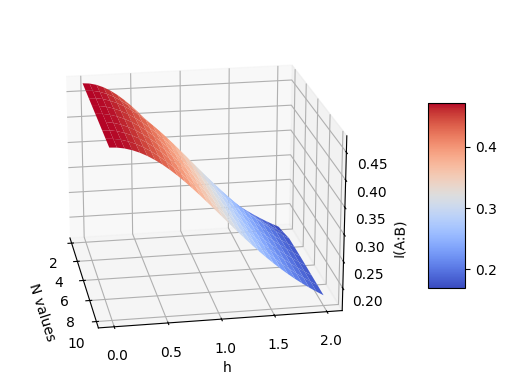

In [ ]:
Z = np.array(I)

x = np.arange(2, N_max)   # columns
y = np.linspace(0, h_m, spac) 
X, Y = np.meshgrid(x, y)

fig = plt.figure()
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='coolwarm')

ax.view_init(elev=20, azim=350)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

ax.set_xlabel('N values')
ax.set_ylabel('h ')
ax.set_zlabel('I(A:B)')

plt.tight_layout()
plt.show()

### 1.2) I now look to one section of this to see if indeed the lines are constants or if finite size effects are observable

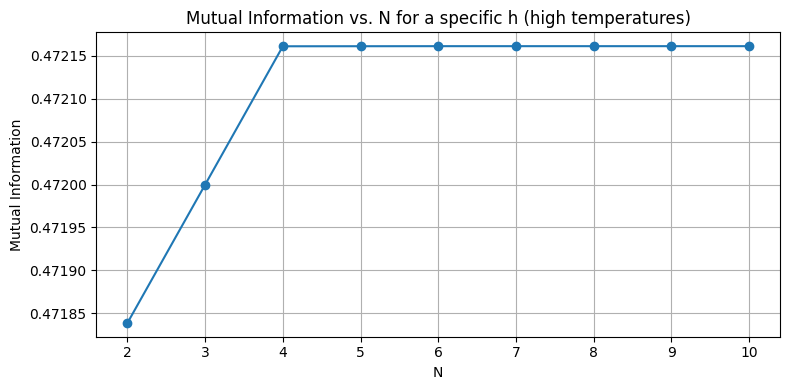

In [79]:
plt.figure(figsize=(8, 4))
plt.plot(x, I[1],marker='o')
plt.xlabel('N')
plt.ylabel('Mutual Information')
plt.title('Mutual Information vs. N for a specific h (high temperatures)')
plt.grid(True)
plt.tight_layout()
plt.show()

### we see that except for really small systems I(A:B) is constant also for the quantum system, also we observe that the simulation agrees with the analytic result I've got that is I(A:B) = 0.4795

### 1.3) We now do the same but for low temperatures and various values of the parameter h

In [52]:
N_max = 12
h_m = 2
J = 1
beta = 15
spac = 30

I = [None] * spac

j = 0

for h in np.linspace(0, h_m, spac):

    I_h = np.zeros(N_max-2)

    for n in range(2,N_max):
        p,b,a = 0,0,0
        p = create_thermal_state(n,J,h,beta)

        # need to create the separation:
        a, b = np.split(np.arange(n ), [ (n ) // 2 ])
        p_A = p.ptrace(a)
        p_B = p.ptrace(b)
        if h == 0:
            p = force_diagonal(p)
            p_A = force_diagonal(p_A)
            p_B = force_diagonal(p_B)
        
        I_h[n-2] = qt.entropy_vn(p_A, base=2) + qt.entropy_vn(p_B, base=2) - qt.entropy_vn(p, base=2)
        
    I[j] = I_h
    j += 1


<Figure size 640x480 with 0 Axes>

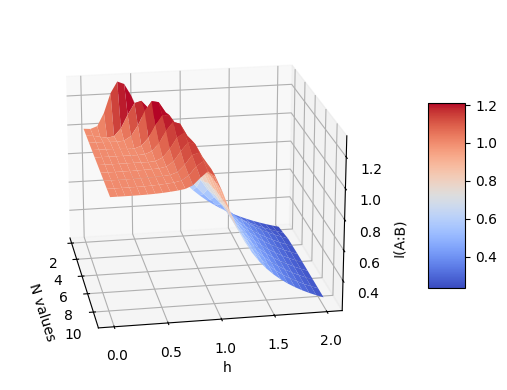

In [ ]:
Z = np.array(I)


x = np.arange(2, N_max)   
y = np.linspace(0, h_m, spac) 
X, Y = np.meshgrid(x, y)


fig = plt.figure()
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='coolwarm')

ax.view_init(elev=20, azim=350)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('N values')
ax.set_ylabel('h ')
ax.set_zlabel('I(A:B)')

plt.tight_layout()
plt.show()

### This behavior is not completely clear to me at the moment, we start correctly with the classical case, so for small temperature I = 1, then we add the quantum behavior and we see that for large chains near quantum criticality there is a spike in the mutual information, that get suppressed when h gets too large. While at small dimensions we see a more complicated behavior with higher spikes but stronger suppression for large values of h

### 1.4) Now we look at how information is lost due to h, that is we take a slice of the 3D plot to see how h kills mutual information

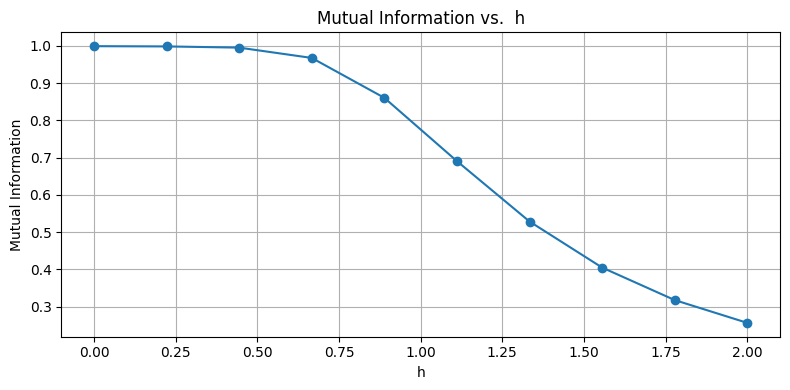

In [13]:
N_max = 10
h_m = 2
J = 1
beta = 5
spac = 10

I_max = np.zeros(spac)

j = 0

for h in np.linspace(0, h_m, spac):

    I_h = np.zeros(N_max-2)

    for n in range(2,N_max):
        p,b,a = 0,0,0
        p = create_thermal_state(n,J,h,beta)

        # need to create the separation:
        a, b = np.split(np.arange(n ), [ (n ) // 2 ])
        p_A = p.ptrace(a)
        p_B = p.ptrace(b)
        if h == 0:
            p = force_diagonal(p)
            p_A = force_diagonal(p_A)
            p_B = force_diagonal(p_B)
        
        I_h[n-2] = qt.entropy_vn(p_A, base=2) + qt.entropy_vn(p_B, base=2) - qt.entropy_vn(p, base=2)
        
    I_max[j] = np.max(I_h)
    j += 1


h_vals = np.linspace(0, h_m, spac)

plt.figure(figsize=(8, 4))
plt.plot(h_vals, I_max,marker='o')
plt.xlabel('h')
plt.ylabel('Mutual Information')
plt.title('Mutual Information vs.  h')
plt.grid(True)
plt.tight_layout()
plt.show()




# 2) We now put our focus on the undestanding of I(A:B|C) behavior

### 2.1) We start for a 11 sites system and different values of h, we should observe at least a 0 value for h = 0 so the classical case, and lets see what appens for other states for different values of h, we keep a single site separation for the moment.

[4.44089210e-15 6.83806840e-04 2.56852010e-03 5.20698542e-03
 8.01503202e-03 1.04559129e-02 1.21897055e-02 1.31241328e-02
 1.33622737e-02 1.31009352e-02 1.25416540e-02 1.18429141e-02
 1.11088138e-02 1.03972685e-02 9.73397267e-03 9.12516184e-03
 8.56701789e-03 8.05178483e-03 7.57133015e-03 7.11891947e-03
 6.68983143e-03 6.28128729e-03 5.89203919e-03 5.52185083e-03
 5.17101271e-03 4.83996228e-03 4.52902886e-03 4.23829281e-03
 3.96753365e-03 3.71623898e-03 3.48364856e-03 3.26881421e-03
 3.07066213e-03 2.88804955e-03 2.71981208e-03 2.56480026e-03
 2.42190611e-03 2.29008075e-03 2.16834499e-03 2.05579434e-03
 1.95160010e-03 1.85500760e-03 1.76533265e-03 1.68195693e-03
 1.60432284e-03 1.53192818e-03 1.46432086e-03 1.40109401e-03
 1.34188122e-03 1.28635234e-03]


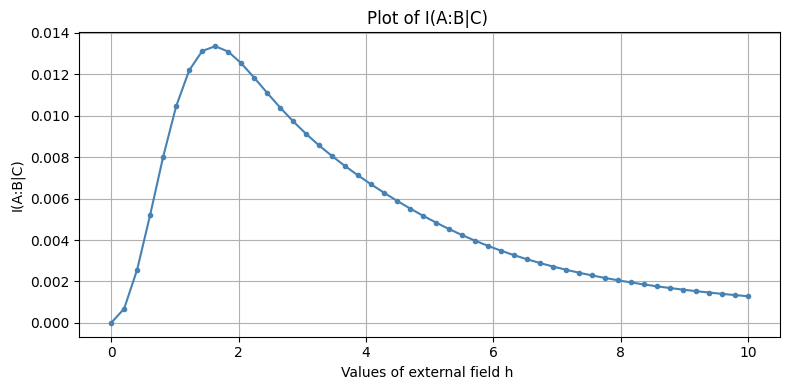

In [ ]:
N = 11
J = 1
beta = 1
h_max = 10
spacing = 50

a = [0,1,2,3,4]
c = [5]
b = [6,7,8,9,10]
I_ABcC = np.zeros(len(np.linspace(0, h_max, spacing)))
i=0
for H in np.linspace(0, h_max, spacing):
    
    p = create_thermal_state(N,J,H,beta)
    
    p_AC = p.ptrace(a+c)
    p_BC = p.ptrace(c+b)
    p_C = p.ptrace(c)
    
    I_ABcC[i] = qt.entropy_vn(p_AC, base=2) + qt.entropy_vn(p_BC, base=2) - qt.entropy_vn(p, base=2)- qt.entropy_vn(p_C, base=2)

    i+=1


x = np.linspace(0, h_max, spacing)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x, I_ABcC, marker='.', linestyle='-', color='steelblue')
plt.title("Plot of I(A:B|C) ")
plt.xlabel("Values of external field h ")
plt.ylabel("I(A:B|C)")
plt.grid(True)
plt.tight_layout()

### We can observe that increasing h we build long range correlations that are not explainable through c, but if we incrase it too much we lose information due to random quantum fluctuations so the I(A:B|C) starts to decrease again

### 2.2) Now we try to see how these values depends on the dimensions of the intermediate system and compare it with the law in the paper by wolf 
$$I(A:B) \leq log(D)l_c O(e^{-\frac{l_c}{\xi}})$$

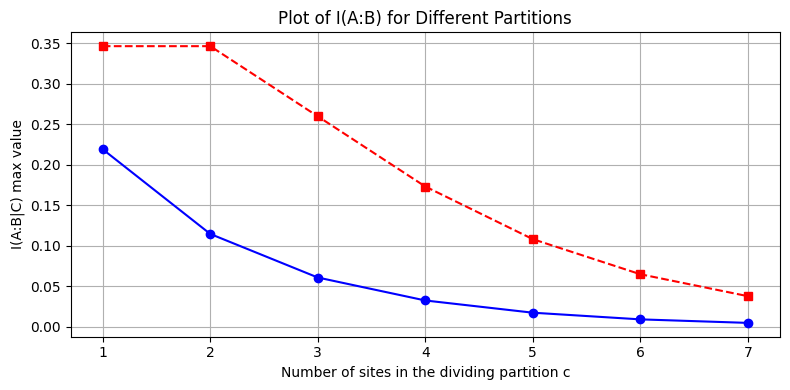

In [17]:

n = 9
J = 1
beta = 1
h_q = 0.5
c_range = list(range(1, n -1))

# Define the partitions to test
partitions = generate_partitions(n)

# Plotting setup

I_ABcC = np.zeros(len(c_range))
I_theory = np.zeros(len(c_range))

for idx, part in enumerate(partitions):
    a = part["a"]
    c = part["c"]
    b = part["b"]
    
    p = create_thermal_state(n, J, h_q, beta)
    p_A = p.ptrace(a)
    p_B = p.ptrace(b)
    p_AB = p.ptrace(a + b)

    I_ABcC[idx] = (qt.entropy_vn(p_A, base=2) + qt.entropy_vn(p_B, base=2) - qt.entropy_vn(p_AB, base=2))
    I_theory[idx] = np.log(2)*len(c)*np.e**(-len(c)/corr_length(h_q,J))
    



plt.figure(figsize=(8, 4))
plt.plot(c_range, I_ABcC,linestyle='-', marker='o', color = 'blue' )
plt.plot(c_range, I_theory,linestyle='--', marker='s', color = 'red')
plt.title("Plot of I(A:B) for Different Partitions")
plt.xlabel("Number of sites in the dividing partition c")
plt.ylabel("I(A:B|C) max value")
plt.grid(True)
plt.tight_layout()
plt.show()
